In [66]:
import evaluate
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# reading the dataset and printing the prompts used for translation 

file_path = 'mt_for_eval.json'

with open(file_path, 'r') as json_file:
    translation_data = json.load(json_file)

prompts = set()

for label in translation_data.values():
    label_prompts = list(label.keys())
    prompts.update(label_prompts)

prompt_names = {}

for num, prompt in enumerate(prompts):
     prompt_name = 'Prompt '+str(num+1)
     prompt_names[prompt] = prompt_name
     print(prompt_name, '\n', prompt)

Prompt 1 
 You are an expert translator that will be tasked with translating a piece of text into Russian. The translation must be faithful to the original tone of voice and writing style. Ensure that the meaning of the original text is not changed. The text to be translated is:
Prompt 2 
 You are an expert translator. Translate the following text to Russian using vocabulary and expressions of a Russian native. The text to be translated is:


### BLEU

The BLEU (Bilingual Evaluation Understudy) metric calculates its score by looking at the overlap between the words and phrases in the machine-translated text and the reference translation. It counts the number of matching words and gives higher weight to longer matches. Then, it calculates a precision score based on these matches. Finally, it combines these precision scores to give an overall BLEU score, which indicates how well the machine translation matches the reference translation.\
\
\
https://huggingface.co/spaces/evaluate-metric/bleu \
https://www.baeldung.com/cs/nlp-bleu-score

In [67]:
bleu = evaluate.load("bleu")

In [82]:
# creating lists of values from the dataset for evaluation on BLEU

data_bleu = []

for label, prompts in translation_data.items():
    for prompt, translations in prompts.items():
        machine_translations = []
        human_translations = []
        for translation in translations:
            machine_translations.extend(translation[1])    # extending to a list of all translated sentences under the same label
            human_translations.extend(translation[2])

        data_bleu.append([label, prompt_names[prompt], [machine_translations, human_translations]])

In [83]:
# calculating the BLEU scores

for item in data_bleu:
    predictions = item[2][0]
    references = item[2][1]
    results = bleu.compute(predictions=predictions, references=references)
    bleu_score = results['bleu']
    item.append(bleu_score)

df_bleu = pd.DataFrame(data_bleu, columns = ['label', 'prompt', 'translations', 'bleu_score'])
df_bleu.drop(columns=['translations'], axis=1, inplace=True)
df_bleu

,label,prompt,bleu_score
0,literature,Prompt 2,0.094569
1,literature,Prompt 1,0.088785
2,medical,Prompt 2,0.035462
3,medical,Prompt 1,0.031622
4,law,Prompt 2,0.103872
5,law,Prompt 1,0.091450


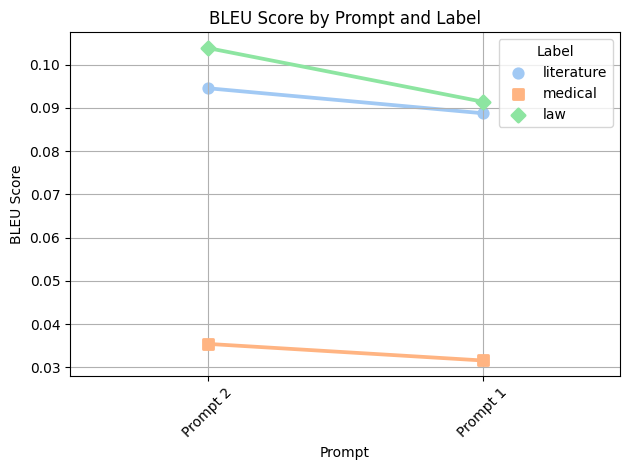

In [71]:
# plotting the results

sns.pointplot(data=df_bleu, x='prompt', y='bleu_score', hue='label', dodge=False, markers=["o", "s", "D"], palette='pastel')
plt.title('BLEU Score by Prompt and Label')
plt.xlabel('Prompt')
plt.ylabel('BLEU Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Label')
plt.grid(True)  # Add grid
plt.show()

### COMET

COMET (Crosslingual Optimized Metric for Evaluation of Translation) is a metric for automatic evaluation of machine translation that calculates the similarity between a machine translation output and a reference translation using token or sentence embeddings.
It is based on similarity of vector representations. \
A score close to 1 indicates a high-quality translation, while a score close to 0 indicates a translation that is no better than random chance.
\
\
https://github.com/Unbabel/COMET

In [72]:
from comet import download_model, load_from_checkpoint

model_path = download_model("Unbabel/wmt22-comet-da")  # default COMET model

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [73]:
# Load the model checkpoint:
model = load_from_checkpoint(model_path)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\svvlk\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
Encoder model frozen.
c:\Users\svvlk\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [74]:
# converting the data into the format accepted by the COMET model

data_comet = translation_data.copy()

for label, prompts in data_comet.items():
    for prompt, translations in prompts.items():
        comet_translations = []
        for translation in translations: 
            comet_translation = {"src": translation[0], "mt": translation[1], "ref": translation[2]}
            comet_translations.append(comet_translation)
        data_comet[label][prompt] = comet_translations

In [75]:
# calculating the COMET scores

comet_scores = []

for label, prompts in data_comet.items():
    for prompt, translations in prompts.items():
        model_output = model.predict(translations, batch_size=8, gpus=0)
        comet_score = [label, prompt_names[prompt], model_output['system_score']]
        comet_scores.append(comet_score)
        
df_comet = pd.DataFrame(comet_scores, columns = ['label', 'prompt', 'comet_score'])
df_comet

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:10<00:00, 10.87s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:10<00:00, 10.73s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:10<00:00, 10.95s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:11<00:00, 11.20s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fa

,label,prompt,comet_score
0,literature,Prompt 2,0.828214
1,literature,Prompt 1,0.831568
2,medical,Prompt 2,0.905302
3,medical,Prompt 1,0.901853
4,law,Prompt 2,0.919184
5,law,Prompt 1,0.917133


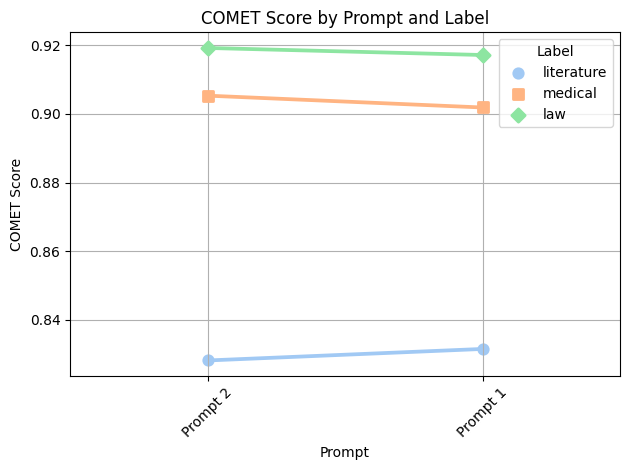

In [76]:
# plotting the results

sns.pointplot(data=df_comet, x='prompt', y='comet_score', hue='label', dodge=False, markers=["o", "s", "D"], palette='pastel')
plt.title('COMET Score by Prompt and Label')
plt.xlabel('Prompt')
plt.ylabel('COMET Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Label')
plt.grid(True)  # Add grid
plt.show()

From the provided BLEU and COMET scores for different prompts and text genres, we can draw several conclusions:

1. Comparison of Prompt Performance:

* Prompt 2 generally outperforms Prompt 1 in both BLEU and COMET metrics across all text genres. This indicates that Prompt 2 might be more effective in guiding the GPT-3.5-Turbo model to produce translations that are closer to the reference translations.
2. Text Genre Comparison:

* Legal texts exhibit higher scores on both BLEU and COMET metrics. This can be attributed to the presence of specialized terminology and structured language typical in legal documents. The use of precise legal terminology might result in high word and phrase overlap (as measured by BLEU), while maintaining semantic similarity (as captured by COMET).

* Literature translations received high scores on BLEU but low scores on COMET, which is unexpected. Literary translations typically involve various interpretations and don't necessarily align closely with the reference. The lower COMET score might stem from the complexity of literary texts, resulting in lower semantic similarity scores.

* Medical texts scored high on COMET but low on BLEU. This pattern can be explained by the presence of highly specialized terminology in medical documents. While the translations might accurately convey the meaning and maintain semantic similarity (as reflected in the high COMET scores), they might not have as high a word and phrase overlap with the reference translations due to the unique vocabulary and complex sentence structures.

Overall Model Performance:

The GPT-3.5-Turbo model demonstrates better performance in terms of semantic similarity (as measured by COMET) compared to word overlap (as measured by BLEU). This suggests that while the literal word overlap might vary, the overall meaning and semantic content of the translations are well-preserved.

It would be beneficial to analyze specific examples where the model performs well/poorly to understand the strengths and weaknesses of the translations produced by each prompt and for each text genre.
Fine-tuning the prompts, collecting a larger dataset, or exploring other techniques to improve translation quality, especially for challenging text genres like literature and medical texts, could be considered.